# A graph-embedded deep feedforward network for disease outcome

classification and feature selection using gene expression data

CSI 5180 - Machine Learning for Bioinformatics

Marcel Turcotte (School of Electrical Engineering and Computer Science,
University of Ottawa)  
2025-03-26

In this notebook, we aim to partially replicate the study conducted by
Kong & Yu:

-   Kong, Y. & Yu, T. (2018). A graph-embedded deep feedforward network
    for disease outcome classification and feature selection using gene
    expression data. *Bioinformatics (Oxford, England)*, *34*(21),
    3727–3737.

We focus on synthetic data, implement a graph-embedded deep feedforward
network using Keras, as well as a baseline model.

# Summary of Work

-   Gene expression data poses a challenge in predictive modeling due to
    the small number of samples compared to the large number of
    features.
-   This disparity, known as the ‘n \<\< p’ problem, hinders the
    application of deep learning techniques for disease outcome
    classification.
-   Sparse learning using external gene network information is a
    potential solution but remains challenging due to the vast number of
    features and limited training samples.
-   The scale-free structure of gene networks complicates the use of
    convolutional neural networks.
-   Kong & Yu proposed a Graph-Embedded Deep Feedforward Networks
    (GEDFN) integrating external relational information into deep neural
    network architecture.

# Prepration

This section regroups all the necessary import statements.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from scipy.stats import multivariate_normal

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Synthetic data generation

Gene expression data is produced under the assumption that the
expression levels of adjacent genes within a gene network exhibit
correlation.

First, a scale-free graph is generated using the preferential attachment
algorithm proposed by Barabási–Albert.

Let’s generate and visualize a small network.

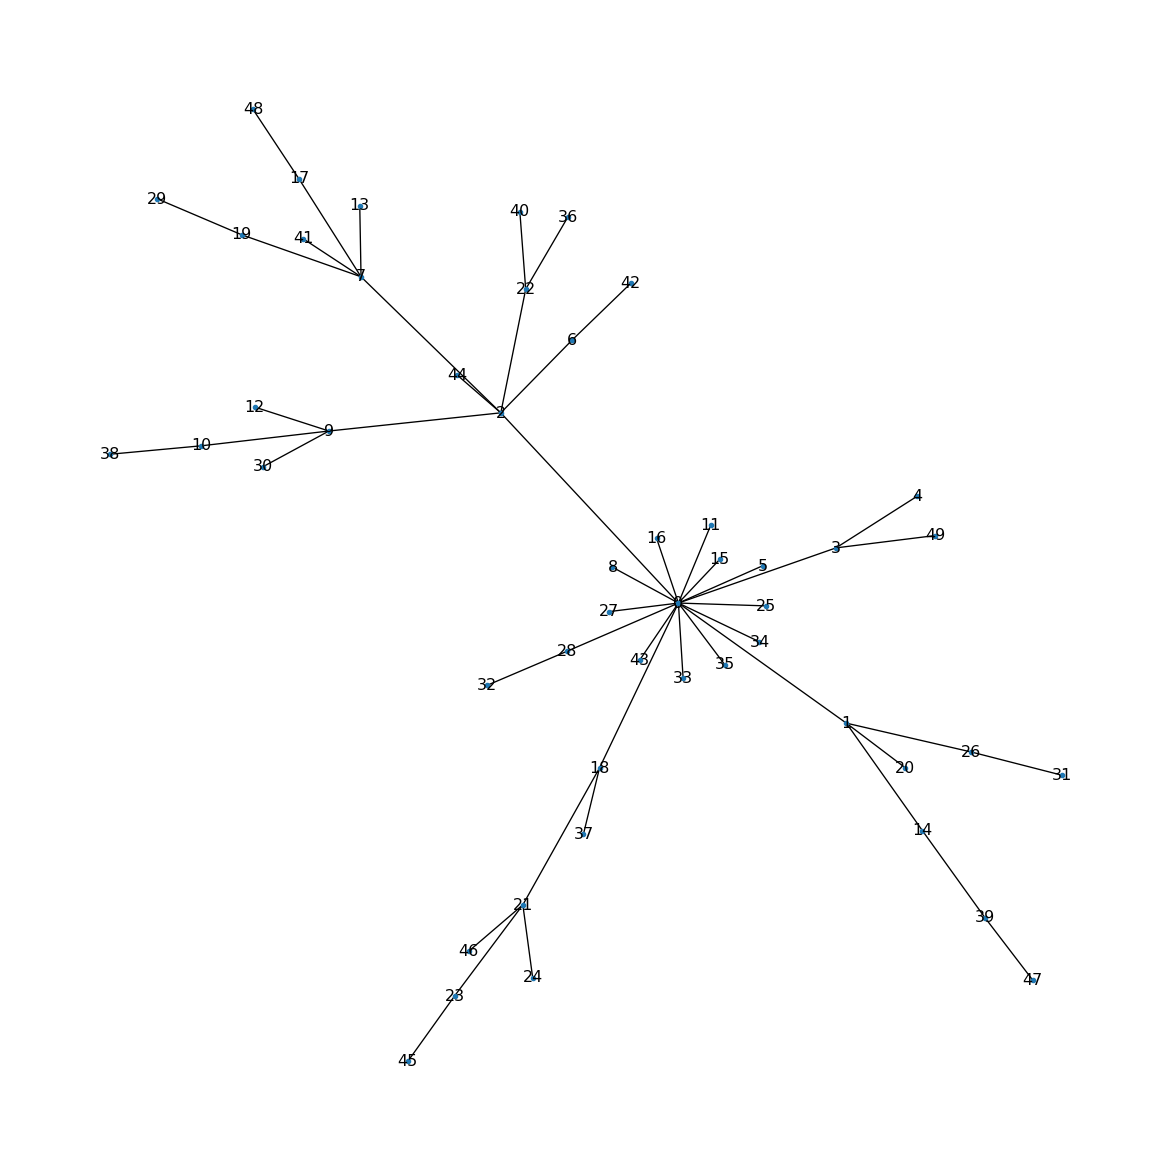

In [2]:
p = 50  # number of features (genes)
m = 1   # number of edges to attach from a new node to existing nodes.

G = nx.barabasi_albert_graph(p, m, seed=42)

pos = nx.spring_layout(G, k=0.1, iterations=100)  # Adjust k as needed
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=10, with_labels=True, labels={node: node for node in G.nodes()})
plt.show()

Analogous to biological networks, certain nodes exhibit a high degree of
connectivity, thereby forming hubs.

We will now implement the necessary functions for generating gene
expression data, grounded in a graph framework and the previously
outlined assumptions.

In [3]:
def generate_scale_free_graph(p, m=1):
    """
    Generate a scale-free graph using the Barabási–Albert model.
    
    Args:
        p (int): Number of nodes (features).
        m (int): Number of edges to attach from a new node to existing nodes.
    
    Returns:
        G (networkx.Graph): A scale-free network.
    """
    G = nx.barabasi_albert_graph(p, m, seed=42)
    return G

def compute_distance_matrix(G):
    """
    Compute the pairwise shortest-path distance matrix D for graph G.
    
    Args:
        G (networkx.Graph): The feature graph.
    
    Returns:
        D (np.ndarray): A (p x p) matrix of shortest-path distances.
    """
    p = G.number_of_nodes()
    D = np.zeros((p, p))
    for i in range(p):
        lengths = nx.single_source_shortest_path_length(G, i)
        for j in range(p):
            D[i, j] = lengths.get(j, np.inf)
    return D

def generate_covariance_matrix(D, decay=0.7):
    """
    Generate a covariance matrix R from the distance matrix D.
    
    Args:
        D (np.ndarray): Distance matrix.
        decay (float): Decay factor; R[i,j] = decay^(D[i,j]).
    
    Returns:
        R (np.ndarray): Covariance matrix.
    """
    R = np.power(decay, D)
    np.fill_diagonal(R, 1.0)
    return R

def select_true_predictors(G, p0, s0=0.0):
    """
    Select true predictors based on the feature graph.
    
    The method selects nodes with high degree (cores) and includes some of their neighbors.
    
    Args:
        G (networkx.Graph): Feature graph.
        p0 (int): Total number of true predictors to select.
        s0 (float): Proportion of 'singletons' amongst the true predictors.
    
    Returns:
        true_idx (np.ndarray): Array of indices for true predictors.
    """
    degrees = dict(G.degree())
    # Sort nodes by degree (highest first)
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    
    # Choose cores: for example, choose k = max(1, p0//20) top nodes
    k = max(1, p0 // 20)
    cores = [node for node, deg in sorted_nodes[:k]]

    # Determine the number of singletons
    nb_singletons = int(np.ceil(s0 * p0))

    # Remove singletons from the total number of predictors
    p0 -= nb_singletons
    
    true_predictors = set(cores)
    # Add neighbors of each core until we have p0 predictors
    for core in cores:
        neighbors = list(G.neighbors(core))
        np.random.shuffle(neighbors)
        for neighbor in neighbors:
            if len(true_predictors) < p0:
                true_predictors.add(neighbor)
            else:
                break
        if len(true_predictors) >= p0:
            break
    # If not enough, add additional high-degree nodes
    for node, deg in sorted_nodes:
        if len(true_predictors) < p0:
            true_predictors.add(node)
        else:
            break

    while nb_singletons > 0:
        singleton = np.random.choice(list(G.nodes()))
        if singleton not in true_predictors:
            true_predictors.add(singleton)
            nb_singletons -= 1

    true_idx = np.array(list(true_predictors))[:p0]
    return true_idx

def generate_outcome(X, true_idx, b_range=(0.1, 0.2), threshold=0.5, link='sigmoid'):
    """
    Generate binary outcome variables using a generalized linear model.
    
    Args:
        X (np.ndarray): Input data matrix (n x p).
        true_idx (np.ndarray): Indices of true predictors.
        b_range (tuple): Range for sampling coefficients.
        threshold (float): Threshold for converting probabilities to binary outcomes.
        link (str): Link function ('sigmoid' or 'tanh_quad').
        
    Returns:
        y (np.ndarray): Binary outcome vector (n,).
        b (np.ndarray): Coefficients for true predictors.
        b0 (float): Intercept.
        prob (np.ndarray): Computed probabilities.
    """
    p0 = len(true_idx)
    # Sample coefficients uniformly from b_range
    b = np.random.uniform(b_range[0], b_range[1], size=p0)
    # Randomly flip signs (to allow both positive and negative effects)
    signs = np.random.choice([-1, 1], size=p0)
    b = b * signs
    b0 = np.random.uniform(b_range[0], b_range[1])
    
    # Compute linear combination for each sample
    linear_term = np.dot(X[:, true_idx], b) + b0
    
    if link == 'sigmoid':
        prob = 1 / (1 + np.exp(linear_term)) # MT: was np.exp(-linear_term)
    elif link == 'tanh_quad':
        # Example non-monotone function: weighted tanh plus quadratic, then min-max scaling.
        raw = 0.7 * np.tanh(linear_term) + 0.3 * (linear_term ** 2)
        raw_min, raw_max = raw.min(), raw.max()
        if raw_max > raw_min:
            prob = (raw - raw_min) / (raw_max - raw_min)
        else:
            prob = np.zeros_like(raw)
    else:
        raise ValueError("Unknown link function.")
    
    # Generate binary outcomes by thresholding the probabilities
    y = (prob > threshold).astype(int)
    return y, b, b0, prob

def generate_synthetic_data(n=400, p=5000, p0=40, s0=0.0, decay=0.7, m=1, link='sigmoid',
                            b_range=(0.1, 0.2), threshold=0.5, random_seed=42):
    """
    Generate synthetic gene expression data and binary outcomes as described in Kong & Yu (2018).
    
    Args:
        n (int): Number of samples.
        p (int): Number of features (genes).
        p0 (int): Number of true predictors.
        decay (float): Decay factor for covariance matrix.
        m (int): Number of edges to attach from a new node in the Barabási–Albert model.
        link (str): Link function ('sigmoid' or 'tanh_quad').
        b_range (tuple): Range for sampling coefficients.
        threshold (float): Threshold for binary outcome generation.
        random_seed (int): Random seed for reproducibility.
    
    Returns:
        X (np.ndarray): Generated input data (n x p).
        y (np.ndarray): Binary outcomes (n,).
        true_idx (np.ndarray): Indices of true predictors.
        R (np.ndarray): Covariance matrix used.
        G (networkx.Graph): The generated feature graph.
        b (np.ndarray): True coefficients for the predictors.
        b0 (float): Intercept.
        prob (np.ndarray): Underlying probabilities.
    """
    np.random.seed(random_seed)
    
    # Generate a scale-free feature graph
    G = generate_scale_free_graph(p, m=m)
    
    # Compute the distance matrix D based on shortest paths in G
    D = compute_distance_matrix(G)
    
    # Generate covariance matrix R: R[i,j] = decay^(D[i,j])
    R = generate_covariance_matrix(D, decay=decay)
    
    # Generate n samples from a multivariate normal with covariance R
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=n)
    
    # Select true predictors from the graph (aiming for clique-like structures)
    true_idx = select_true_predictors(G, p0, s0)
    
    # Generate binary outcomes using a generalized linear model
    y, b, b0, prob = generate_outcome(X, true_idx, b_range=b_range, threshold=threshold, link=link)
    
    return X, y, true_idx, R, G, b, b0, prob

Focusing now on the portion where gene expression data is generated.

In [4]:
p = 5000    # number of features (genes)
n = 400     # number of examples (samples)
m = 1       # number of edges to attach from a new node to existing nodes.
p0 = 40     # number of true predictors
decay = 0.7

G = generate_scale_free_graph(p, m=m)

D = compute_distance_matrix(G)
R = generate_covariance_matrix(D, decay=decay)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=n)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The authors explained that, within this framework, vertices that are
separated by multiple steps may inherently exhibit negative correlations
when expression values are sampled from a multivariate normal
distribution characterized by a variance-covariance matrix. The
following replicates Figure 2 from the supplementary information.

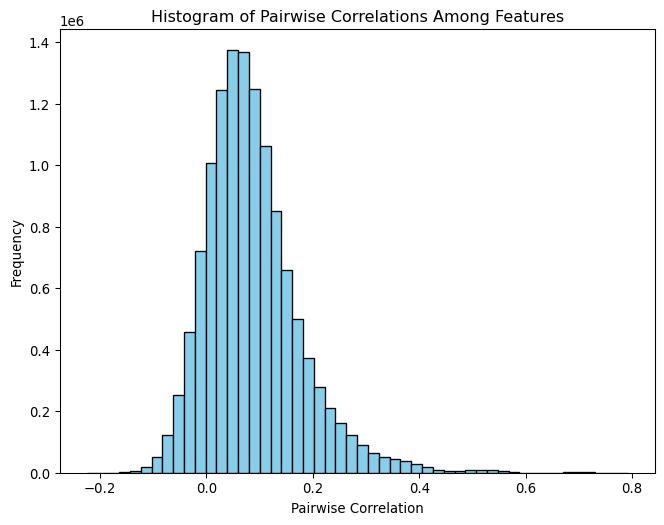

In [5]:
# Compute the pairwise correlation matrix.
# Set rowvar=False because features are columns.

corr_matrix = np.corrcoef(X_scaled, rowvar=False)

# Extract the lower-triangular part (excluding the diagonal)
# to get all unique pairwise correlations.

tril_indices = np.tril_indices_from(corr_matrix, k=-1)
corr_values = corr_matrix[tril_indices]

# Visualize the histogram of pairwise correlations.
plt.figure(figsize=(8, 6))
plt.hist(corr_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Pairwise Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of Pairwise Correlations Among Features")
plt.show()

# Deep Learning

## Defining a Baseline Model

In [6]:
def create_baseline_model(input_dim, hidden_dims):

    """
    Creates a baseline deep feedforward network with the same architecture
    as the graph-embedded model but without domain-specific graph information.
    
    Architecture:
      - Input layer of dimension 'input_dim'.
      - First hidden layer: Fully connected mapping from input to an output 
        with the same dimension (i.e. input_dim), with ReLU activation.
      - Additional Dense hidden layers as specified in hidden_dims.
      - Final output layer with a single neuron for binary classification.
    
    Args:
      input_dim (int): Number of input features.
      hidden_dims (list of int): List of hidden layer sizes after the first layer.
    
    Returns:
      model (tf.keras.Model): The baseline Keras model.
    """

    inputs = keras.Input(shape=(input_dim,))
    
    # First hidden layer: fully connected (without graph-based filtering)
    x = layers.Dense(input_dim, activation="relu", name="baseline_fc1")(inputs)
    
    # Additional hidden layers
    for i, hdim in enumerate(hidden_dims):
        x = layers.Dense(hdim, activation="relu", name=f"baseline_fc{i+2}")(x)
    
    # Final output layer (for binary classification)
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Defining a Graph-Embedded Neural Network Model Based on Kong & Yu (2018)

In [7]:
# Custom graph-embedded Dense layer (for reference)

class GraphEmbeddedDense(layers.Layer):
    def __init__(self, units, mask, use_bias=True, **kwargs):

        """
        Custom Dense layer that embeds a feature graph.
        
        Args:
            units (int): Number of output units (typically equals the input dimension).
            mask (np.array or tf.Tensor): Adjacency matrix of shape (input_dim, units).
            use_bias (bool): Whether to include a bias term.
        """

        super(GraphEmbeddedDense, self).__init__(**kwargs)
        self.units = units
        self.mask = tf.constant(mask, dtype=tf.float32)
        self.use_bias = use_bias

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        self.kernel = self.add_weight(
            shape=(input_dim, self.units),
            initializer=tf.keras.initializers.HeUniform(),
            trainable=True,
            name="kernel"
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.units,),
                initializer="zeros",
                trainable=True,
                name="bias"
            )
        else:
            self.bias = None
        super(GraphEmbeddedDense, self).build(input_shape)

    def call(self, inputs):
        masked_kernel = self.kernel * self.mask
        output = tf.matmul(inputs, masked_kernel)
        if self.use_bias:
            output = output + self.bias
        return output

### Build a Keras model that uses the custom graph-embedded layer.

def create_graph_model(input_dim, hidden_dims, mask):
    inputs = keras.Input(shape=(input_dim,))
    # Graph-embedded layer: name it "graph_layer"
    x = GraphEmbeddedDense(units=input_dim, mask=mask, name="graph_layer")(inputs)
    x = layers.ReLU()(x)
    # First fully connected layer, name it "fc1"
    x = layers.Dense(hidden_dims[0], activation="relu", name="fc1")(x)
    # Additional Dense layers (if any)
    for hdim in hidden_dims[1:]:
        x = layers.Dense(hdim, activation="relu")(x)
    # Final output layer for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_feature_importance_keras(model):

    """
    Evaluate feature importance using the GCW method from Kong & Yu (2018).
    
    Assumptions:
      - The graph-embedded layer is named "graph_layer". It has attributes:
            • kernel: trainable weight matrix of shape (p, p)
            • mask: fixed binary tensor (adjacency matrix) of shape (p, p)
      - The first Dense layer following the graph layer is named "fc1" 
        and has kernel shape (p, h1), where rows correspond to input features.
    
    Returns:
        importance: a tensor of shape (p,) with the computed importance scores.
    """

    # Retrieve the graph-embedded layer
    graph_layer = model.get_layer("graph_layer")
    # Retrieve the trainable kernel and the fixed mask
    W_in = graph_layer.kernel  # shape: (p, p)
    mask = graph_layer.mask    # shape: (p, p) assumed to be a tf.Tensor
    
    # Compute the effective weight matrix (only allowed connections)
    effective_W = W_in * mask  # element-wise multiplication
    
    # For each feature j, sum the absolute weights from the graph layer.
    # Since Keras Dense layers perform: output = x @ kernel, the j-th column
    # corresponds to contributions from feature j.
    graph_contrib = tf.reduce_sum(tf.abs(effective_W), axis=0)  # shape: (p,)
    
    # Retrieve the first Dense layer after the graph layer (named "fc1")
    fc1 = model.get_layer("fc1")
    # For a Dense layer, kernel shape is (input_dim, units); rows correspond to input features.
    W_fc1 = fc1.kernel  # shape: (p, h1)
    fc1_contrib = tf.reduce_sum(tf.abs(W_fc1), axis=1)  # sum over units → shape: (p,)
    
    # Compute the degree of each feature from the mask (sum over each column)
    degree = tf.reduce_sum(mask, axis=0)  # shape: (p,)
    eps = 1e-8  # to avoid division by zero
    c = 50
    gamma = tf.minimum(tf.ones_like(degree), c / (degree + eps))
    
    # Combine the contributions with the penalty factor
    importance = gamma * graph_contrib + fc1_contrib
    return importance

# Runs

## Creating the Training, Validation, and Test Datasets

In [8]:
# Parameters
n = 400      # number of samples
p = 5000     # number of features
p0 = 40      # number of true predictors

# Generate the synthetic data
X, y, true_idx, R, G, b, b0, prob = generate_synthetic_data(n=n, p=p, p0=p0, random_seed=0)

A = nx.adjacency_matrix(G).todense()

In [9]:
# Split the data: 80% train, 10% validation, 10% test.

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

## Scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_temp = scaler.transform(X_temp)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=0)

keras.utils.set_random_seed(0)

## Create the Baseline Model

In [10]:
input_dim = X_train.shape[1]  # e.g., 500 features in synthetic data.
hidden_dims = [64, 16]
baseline_model = create_baseline_model(input_dim=input_dim, hidden_dims=hidden_dims)
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type) ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 ( InputLayer ) │ ( None , 5000 ) │ 0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_fc1 ( Dense ) │ ( None , 5000 ) │ 25,005,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_fc2 ( Dense ) │ ( None , 64 ) │ 320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_fc3 ( Dense ) │ ( None , 16 ) │ 1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output ( Dense ) │ ( None , 1 ) │ 17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

Total params: 25,326,121 (96.61 MB)

Trainable params: 25,326,121 (96.61 MB)

Non-trainable params: 0 (0.00 B)

## Train and Visualize Training/Validation Loss

Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.6250 - loss: 0.6584 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6997 - loss: 0.6159  5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7232 - loss: 0.6330 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7459 - loss: 0.6357 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7575 - loss: 0.634910/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7641 - loss: 0.6366 - val_accuracy: 0.8750 - val_loss: 0.2948
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9375 - loss: 0.1156

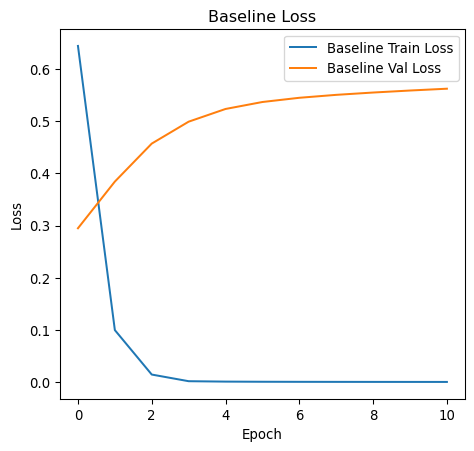

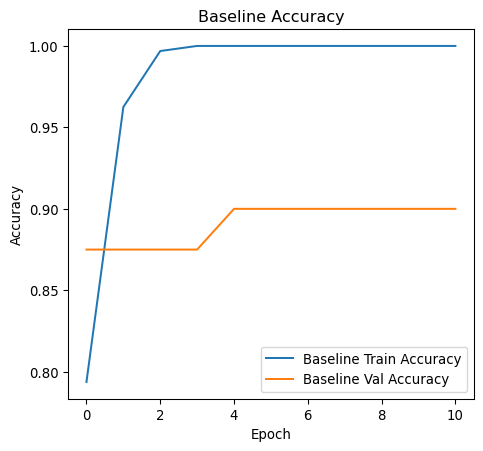

In [11]:
# Define callbacks for early stopping.
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the baseline model.
history_baseline = baseline_model.fit(X_train, y_train, 
                                      validation_data=(X_val, y_val),
                                      epochs=100, batch_size=32, callbacks=callbacks)

# Plot training and validation loss.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Baseline Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Baseline Val Loss')
plt.title("Baseline Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation loss.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Baseline Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Val Accuracy')
plt.title("Baseline Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## Create the Graph-Embedded Model

In [12]:
# Now, use A as the mask for GraphEmbeddedNetwork:
graph_model = create_graph_model(input_dim, hidden_dims, A)
graph_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
graph_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type) ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 ( InputLayer ) │ ( None , 5000 ) │ 0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_layer │ ( None , 5000 ) │ 25,005,000 │
│ ( GraphEmbeddedDense ) │ │ │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 ( ReLU ) │ ( None , 5000 ) │ 0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 ( Dense ) │ ( None , 64 ) │ 320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 ( Dense ) │ ( None , 16 ) │ 1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 ( Dense ) │ ( None , 1 ) │ 17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

Total params: 25,326,121 (96.61 MB)

Trainable params: 25,326,121 (96.61 MB)

Non-trainable params: 0 (0.00 B)

## Train and Visualize Training/Validation Loss

Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.4375 - loss: 0.6943 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6111 - loss: 0.6873  5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6717 - loss: 0.6777 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7083 - loss: 0.6674 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7322 - loss: 0.656510/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7497 - loss: 0.6454 - val_accuracy: 0.8250 - val_loss: 0.4912
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8750 - loss: 0.4832

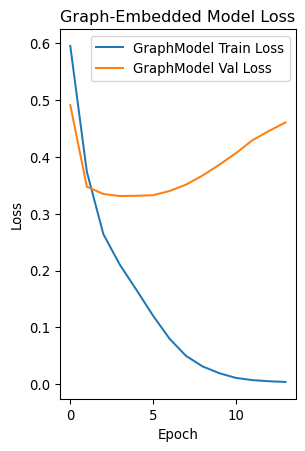

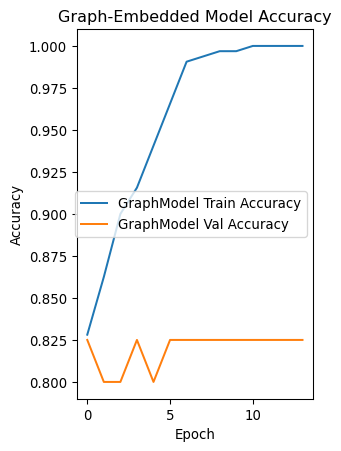

Feature importance scores (shape (5000,)):
[2.9373732 1.7428389 2.3859673 ... 1.2631431 1.1794165 1.4094478]

In [13]:
# Train the graph-embedded model.
history_graph = graph_model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                epochs=100, batch_size=32, callbacks=callbacks)

plt.subplot(1, 2, 2)
plt.plot(history_graph.history['loss'], label='GraphModel Train Loss')
plt.plot(history_graph.history['val_loss'], label='GraphModel Val Loss')
plt.title("Graph-Embedded Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_graph.history['accuracy'], label='GraphModel Train Accuracy')
plt.plot(history_graph.history['val_accuracy'], label='GraphModel Val Accuracy')
plt.title("Graph-Embedded Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

importance_scores = evaluate_feature_importance_keras(graph_model)
print("Feature importance scores (shape {}):".format(importance_scores.shape))
print(importance_scores.numpy())

## Evaluate and Compare the Models on the Test Set

In [14]:
# Evaluate the baseline model.
baseline_eval = baseline_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Model")

y_pred = (baseline_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

Baseline Model
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3f79988b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        22
           1       0.82      0.78      0.80  

In [15]:
# Evaluate the graph-embedded model.
graph_eval = graph_model.evaluate(X_test, y_test, verbose=0)
print("Graph-Embedded Model:")

y_pred = (graph_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

Graph-Embedded Model:
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.88      0.83      0.86        18

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40
